In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv', usecols=['gender', 'age', 'height', 'weight'])

In [3]:
train_df.head()

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
0,M,18.0,"1,674",52.9,790,655,851
1,M,18.0,"1,678",55.8,825,654,880
2,M,23.0,"1,790",57.5,800,650,870
3,F,37.0,"1,626",66.3,962,820,997
4,M,24.0,"1,722",69.2,948,785,937


In [4]:
# checking for nulls in the dataframe
train_df.isnull().sum()

gender                 1
age                    1
height                 2
weight                 7
bust_circumference     4
waist_circumference    4
hip_circumference      4
dtype: int64

In [5]:
# checking for nulls in the dataframe
test_df.isnull().sum()

gender    0
age       0
height    0
weight    1
dtype: int64

In [6]:
# understanding the nature of the nulls
null_rows = train_df[train_df.isnull().any(axis=1)]
null_rows

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
1801,F,19.0,"1,620",NaN,775,622,850
2360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3258,M,17.0,"1,762",NaN,836,690,900
3303,M,31.0,"1,725",NaN,NaN,NaN,NaN
3752,M,20.0,"1,821",NaN,931,762,942
4189,M,22.0,"1,730",NaN,NaN,NaN,NaN
4603,F,63.0,"1,573",NaN,"1,002",910,928
4876,M,37.0,NaN,83.9,NaN,NaN,NaN


In [7]:
# understanding the nature of the nulls
null_rows = test_df[test_df.isnull().any(axis=1)]
null_rows

,gender,age,height,weight
413,M,17.0,"1,740",NaN


In [8]:
# removing rows without data on circumferences
filtered_train = train_df.dropna()
filtered_test = test_df.copy()
filtered_train.isnull().sum()

gender                 0
age                    0
height                 0
weight                 0
bust_circumference     0
waist_circumference    0
hip_circumference      0
dtype: int64

In [9]:
# checking the nature of the dataset
filtered_train.describe(include='all')

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference
count,5129,5129.000000,5129,5129.000000,5129,5129,5129
unique,2,NaN,430,NaN,437,486,347
top,F,NaN,"1,580",NaN,895,760,930
freq,2573,NaN,56,NaN,70,59,90
mean,NaN,31.588224,NaN,63.872431,NaN,NaN,NaN
std,NaN,14.429656,NaN,12.648540,NaN,NaN,NaN
min,NaN,15.000000,NaN,36.800000,NaN,NaN,NaN
25%,NaN,19.000000,NaN,54.600000,NaN,NaN,NaN
50%,NaN,28.000000,NaN,61.700000,NaN,NaN,NaN
75%,NaN,40.000000,NaN,71.500000,NaN,NaN,NaN


In [10]:
# checking the balance of the dataset
gender_counts = filtered_train['gender'].value_counts().reset_index()
gender_counts

,gender,count
0,F,2573
1,M,2556


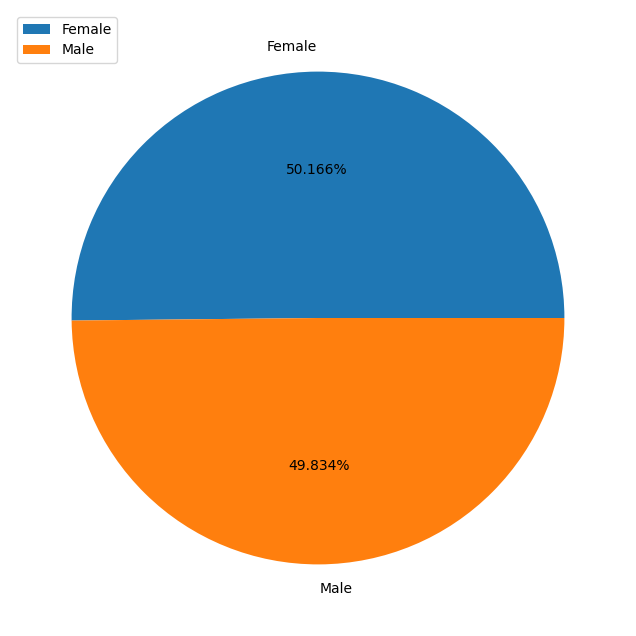

In [11]:
plt.figure(figsize=(8,8))
plt.pie(gender_counts['count'], labels=['Female', 'Male'], autopct='%1.3f%%',explode=[0,0])
plt.legend(loc='upper left')
plt.show()

In [12]:
# checking the data types per column
filtered_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5129 entries, 0 to 5136
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               5129 non-null   object 
 1   age                  5129 non-null   float64
 2   height               5129 non-null   object 
 3   weight               5129 non-null   float64
 4   bust_circumference   5129 non-null   object 
 5   waist_circumference  5129 non-null   object 
 6   hip_circumference    5129 non-null   object 
dtypes: float64(2), object(5)
memory usage: 320.6+ KB


In [13]:
# standardizing numeric data
def clean_and_convert_columns(df, columns):
    df = df.copy()
    for col in columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .astype(float)
        )
    return df

cleaned_train =  clean_and_convert_columns(filtered_train, ['height', 'bust_circumference', 'waist_circumference', 'hip_circumference'])
cleaned_test  =  clean_and_convert_columns(filtered_test, ['height'])

In [14]:
# filling NaNs
for col in ['weight', 'height', 'age']:
    cleaned_test.fillna(cleaned_test[col].median(), inplace=True)

In [15]:
def plot_boxplot(data, x_col, y_col):
    num_plots = len(y_col)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # width scales with number of plots

    if num_plots == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, y_col in zip(axes, y_col):
        sns.boxplot(x=x_col, y=y_col, data=data, ax=ax)
        ax.set_title(f'{y_col} vs {x_col}')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)

    plt.tight_layout()
    plt.show()

In [16]:
def plot_distribution(data, cols):
    num_plots = len(cols)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # width scales with number of plots

    if num_plots == 1:
        axes = [axes]  # Make sure axes is iterable

    for ax, col in zip(axes, cols):
        sns.histplot(data[col], kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

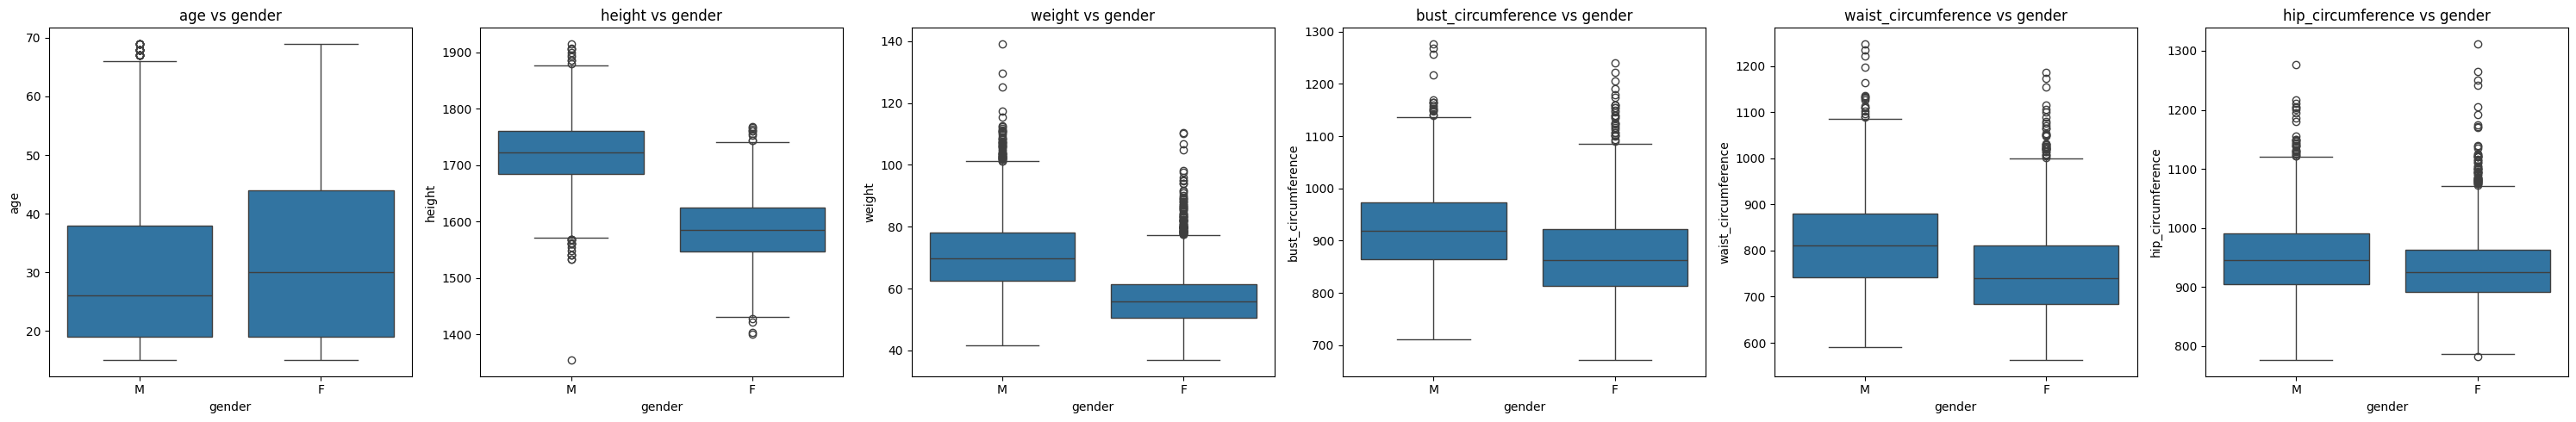

In [17]:
# Creating box plot to check nature of data
plot_boxplot(cleaned_train, 'gender', ['age', 'height', 'weight', 'bust_circumference', 'waist_circumference', 'hip_circumference'])

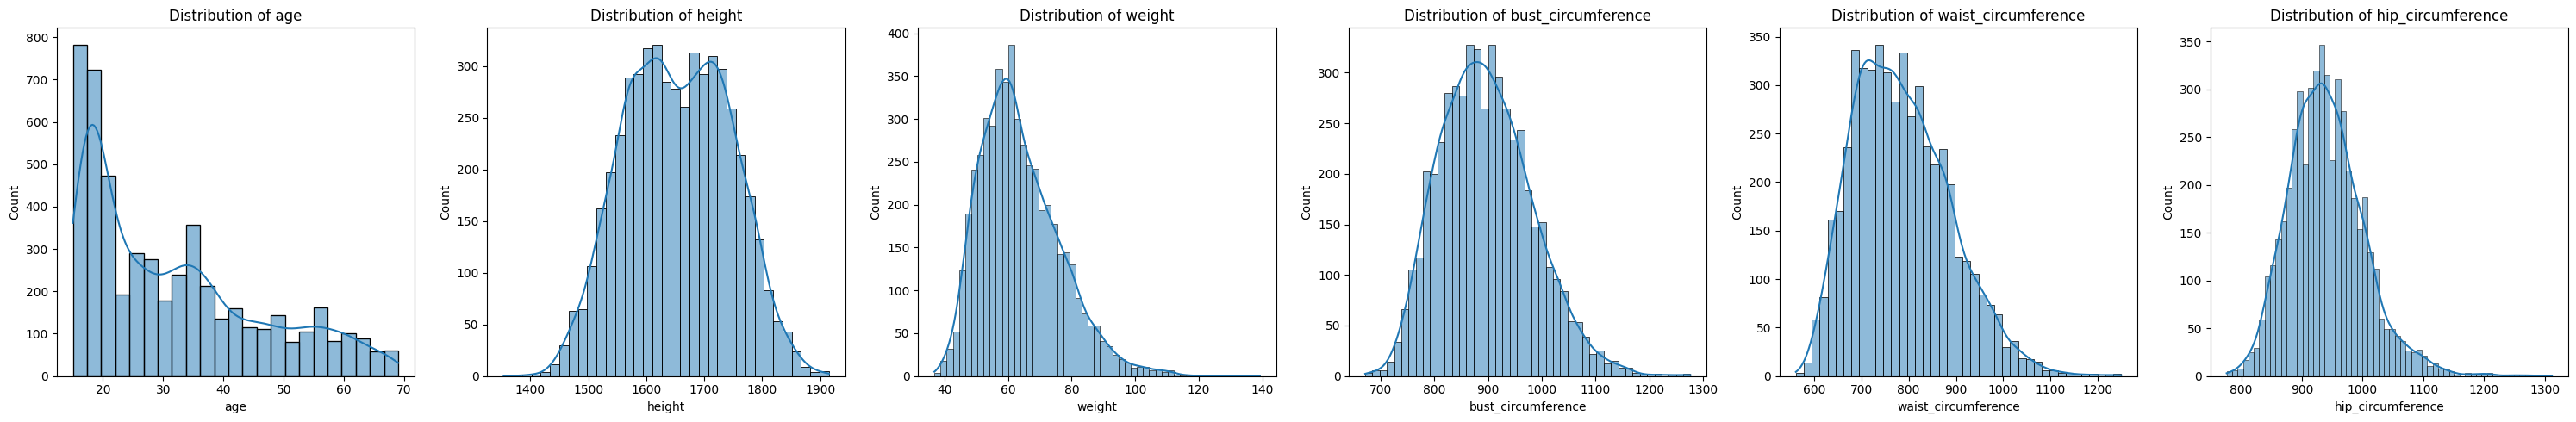

In [18]:
plot_distribution(cleaned_train, ['age', 'height', 'weight', 'bust_circumference', 'waist_circumference', 'hip_circumference'])

In [19]:
# Adding more features to the dataset
def add_features(df):
    df['BMI'] = df['weight'] / ((df['height']/ 1000) ** 2)
    df['weight_height_ratio'] = df['weight'] / df['height']
    
    return df


In [20]:
add_features(cleaned_train)
add_features(cleaned_test)

,gender,age,height,weight,BMI,weight_height_ratio
0,M,27.0,1729.0,74.7,24.987949,0.043204
1,M,25.0,1645.0,58.6,21.655380,0.035623
2,M,28.0,1786.0,75.2,23.575175,0.042105
3,M,19.0,1686.0,60.8,21.388899,0.036062
4,M,24.0,1764.0,68.3,21.949445,0.038719
...,...,...,...,...,...,...
1277,F,33.0,1618.0,54.0,20.627031,0.033375
1278,F,25.0,1549.0,56.4,23.505867,0.036411
1279,F,28.0,1623.0,58.5,22.208480,0.036044
1280,F,34.0,1566.0,55.4,22.590521,0.035377


In [21]:
# Defining features available for both datasets
le = LabelEncoder()
cleaned_train['gender_encoded'] = le.fit_transform(cleaned_train['gender']) 
cleaned_test['gender_encoded'] = le.fit_transform(cleaned_test['gender'])

In [22]:
# Features and targets
feature_cols = ['gender_encoded', 'age', 'height', 'weight', 'BMI', 'weight_height_ratio']
target_cols = ['bust_circumference', 'waist_circumference', 'hip_circumference']

In [23]:
X = cleaned_train[feature_cols]
y = cleaned_train[target_cols]

In [24]:
# Spliting train data into training subset and validation subset
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Initializing models
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
gbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
lr = LinearRegression()
dt = MultiOutputRegressor(DecisionTreeRegressor(random_state=42))

In [26]:
def evaluate_regression_model(y_true, y_pred, target_names):
    for i, target in enumerate(target_names):
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        print(f"{target} - MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

In [27]:
# Train and evaluate Linear Regression
print("Linear Regression Performance on Validation Set:")
lr.fit(X_train_sub, y_train_sub)
y_pred_lr = lr.predict(X_val)
evaluate_regression_model(y_val, y_pred_lr, target_cols)

Linear Regression Performance on Validation Set:
bust_circumference - MAE: 23.693, RMSE: 30.111, R²: 0.873
waist_circumference - MAE: 24.468, RMSE: 31.359, R²: 0.901
hip_circumference - MAE: 17.623, RMSE: 23.195, R²: 0.857


In [28]:
# Train and evaluate Decision Tree
print("\nDecision Tree Performance on Validation Set:")
dt.fit(X_train_sub, y_train_sub)
y_pred_dt = dt.predict(X_val)
evaluate_regression_model(y_val, y_pred_dt, target_cols)


Decision Tree Performance on Validation Set:
bust_circumference - MAE: 34.609, RMSE: 44.365, R²: 0.724
waist_circumference - MAE: 34.482, RMSE: 44.195, R²: 0.803
hip_circumference - MAE: 24.962, RMSE: 32.702, R²: 0.716


In [29]:
# Train and evaluate Random Forest
print("Random Forest Performance on Validation Set:")
rf.fit(X_train_sub, y_train_sub)
y_pred_rf = rf.predict(X_val)
evaluate_regression_model(y_val, y_pred_rf, target_cols)

Random Forest Performance on Validation Set:
bust_circumference - MAE: 24.646, RMSE: 31.305, R²: 0.863
waist_circumference - MAE: 25.642, RMSE: 32.563, R²: 0.893
hip_circumference - MAE: 18.468, RMSE: 24.126, R²: 0.845


In [30]:
# Train and evaluate Gradient Boosting
print("\nGradient Boosting Performance on Validation Set:")
gbr.fit(X_train_sub, y_train_sub)
y_pred_gbr = gbr.predict(X_val)
evaluate_regression_model(y_val, y_pred_gbr, target_cols)


Gradient Boosting Performance on Validation Set:
bust_circumference - MAE: 23.590, RMSE: 29.908, R²: 0.875
waist_circumference - MAE: 24.640, RMSE: 31.377, R²: 0.901
hip_circumference - MAE: 17.648, RMSE: 23.660, R²: 0.851


In [32]:
X_test = cleaned_test[feature_cols]

gbr.fit(X, y)

# Predict on test set
predictions = gbr.predict(X_test)

pred_df = pd.DataFrame(predictions, columns=[
    'bust_circumference',
    'waist_circumference',
    'hip_circumference'
])

pred_df.to_csv('predictions.csv', index=False)